imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_colwidth', None)
import nltk
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import warnings
warnings.simplefilter(action='ignore')
from tqdm.notebook import tqdm

import pickle
import requests
import json

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngeva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ngeva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngeva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


read csv

In [2]:
df_raw = pd.read_csv('pos_and_neg_tweets_final_no_dup.csv')

In [3]:
df = df_raw.loc[:,['text', 'user_followers', 'favorites', 'retweets', 'is_retweet', 'category']]

In [4]:
df = df.drop_duplicates()

In [5]:
df["up_text"] = df.text.str.lower()
df.up_text = df.up_text.apply(lambda x:re.sub('@[^\s]+','',x))
df.up_text = df.up_text.apply(lambda x:re.sub(r'\B#\S+','',x))
df.up_text = df.up_text.apply(lambda x:re.sub(r"http\S+", "", x))
df.up_text = df.up_text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [6]:
contractions_dict = { "ain't": "are not ","'s":" is ","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

df['up_text']=df['up_text'].apply(lambda x:expand_contractions(x))

In [7]:
df['tokenized'] = df['up_text'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

In [8]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['tokenized'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [9]:
wnl = WordNetLemmatizer()
df['tokenized'] = df['tokenized'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [10]:
df['n_words'] = df['up_text'].apply(lambda x: len(x.split()))

split

In [11]:
df.columns

Index(['text', 'user_followers', 'favorites', 'retweets', 'is_retweet',
       'category', 'up_text', 'tokenized', 'pos_tags', 'n_words'],
      dtype='object')

In [12]:
features = list(df.columns)
features.remove('category')

In [13]:
from sklearn.model_selection import train_test_split
X = df[features]
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=df['category'])

finding the most common words to create features

In [14]:
words = X_train['tokenized']
allwords = []
for wordlist in words:
    allwords += wordlist
allwords = [word for word in allwords if word !='amp']
allwords = [word for word in allwords if word !='rt']

In [15]:
mostcommon = FreqDist(allwords).most_common(100)
mostcommon = [tup[0] for tup in mostcommon]

In [16]:
def most_common_token(token):
    new_token=[]
    for word in token:
        if word in mostcommon:
            new_token.append(word)
    return new_token

In [17]:
X_train['tokenized_common'] = X_train['tokenized'].apply(lambda x: most_common_token(x))
X_test['tokenized_common'] = X_test['tokenized'].apply(lambda x: most_common_token(x))

In [18]:
empty_tokens = X_train[(X_train['tokenized_common'].str.len() == 0)].index
X_train = X_train.drop(empty_tokens)
y_train = y_train.drop(empty_tokens)

empty_tokens = X_test[(X_test['tokenized_common'].str.len() == 0)].index
X_test = X_test.drop(empty_tokens)
y_test = y_test.drop(empty_tokens)

In [19]:
for word in mostcommon:
    X_train[word]=0
    X_test[word]=0

In [20]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [21]:
for index, row in tqdm(enumerate(X_train.tokenized_common)):
    for word in row:
        X_train.loc[index,word] = 1
        
for index, row in tqdm(enumerate(X_test.tokenized_common)):
    for word in row:
        X_test.loc[index,word] = 1

In [22]:
y_train = y_train.replace({'Positive':0, 'Negative':1})
X_train['is_retweet'] = X_train['is_retweet'].replace({False:0, True:1})

y_test = y_test.replace({'Positive':0, 'Negative':1})
X_test['is_retweet'] = X_test['is_retweet'].replace({False:0, True:1})

In [23]:
columns_to_drop = ['text', 'up_text', 'pos_tags','tokenized','index','tokenized_common']
X_train = X_train.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

In [24]:
X_train

,user_followers,favorites,retweets,is_retweet,n_words,vaccine,get,covid,make,today,...,like,want,use,love,well,old,moment,last,look,roll
0,491,0,7,1,20,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1525,0,100,1,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6333,0,1,1,23,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,755,0,5,1,21,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,246,0,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12485,273,0,14,1,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12486,602,0,12,1,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12487,3867,0,28,1,18,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12488,194,0,95,1,14,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


model

In [25]:
import xgboost as xgb

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

xgb = XGBClassifier()

folds = 3
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

parameters = {
     "eta"              : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10],
     "min_child_weight" : [ 1, 2, 3, 5 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [0.5 , 0.7, 1]
     }


random_search = RandomizedSearchCV(xgb, param_distributions=parameters, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc',
                                   n_jobs=4, 
                                   cv=skf.split(X_train,y_train), 
                                   verbose=3, 
                                   random_state=1001 )

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[11:40:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000021032D142E0>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tr

In [27]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([15.4233319 , 17.56327097,  7.8975997 ,  6.00443824,  5.33672508]), 'std_fit_time': array([0.16277232, 2.81061986, 0.92422325, 0.17206398, 1.33254377]), 'mean_score_time': array([0.08900166, 0.0803322 , 0.06233525, 0.05400236, 0.04310322]), 'std_score_time': array([0.01512163, 0.01746138, 0.01681769, 0.00725765, 0.00244675]), 'param_min_child_weight': masked_array(data=[2, 3, 5, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 10, 5, 4, 5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.0, 0.1, 0.4, 0.3, 0.4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_eta': masked_array(data=[0.25, 0.15, 0.1, 0.25, 0.25],
             mask=[False, False, False, False, False],
       fill_value='?',
  

In [28]:
model = random_search.best_estimator_

In [29]:
filename = "xgboost.sav"
pickle.dump(model, open(filename, 'wb'))

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report
preds = random_search.predict_proba(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.9206919060052219
Recall = 0.8905764714794333
Accuracy = 0.9226075786769429


In [35]:
prec = round(precision_score(y_test, best_preds, average='macro'),2)
recall = round(recall_score(y_test, best_preds, average='macro'),2)
acc = round(accuracy_score(y_test, best_preds),2)

In [36]:
tn, fp, fn, tp = confusion_matrix(np.array(y_test), best_preds).ravel()
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
auc = roc_auc_score(y_test, preds[:,1])

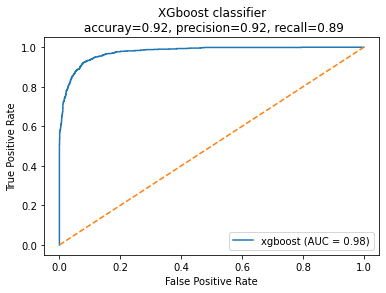

In [38]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='xgboost')
display.plot() 
plt.plot([0,1],[0,1], ls= '--', label = 'ROC curve (area = %0.2f)' % auc)
plt.title('XGboost classifier\n accuray={}, precision={}, recall={}'.format(acc,prec,recall))
plt.show()      

In [43]:
target_names = ['non-anvi-vax', 'anti-vax']
print(classification_report(y_test, best_preds, target_names=target_names))

              precision    recall  f1-score   support

non-anvi-vax       0.92      0.97      0.95      2193
    anti-vax       0.92      0.81      0.86       921

    accuracy                           0.92      3114
   macro avg       0.92      0.89      0.90      3114
weighted avg       0.92      0.92      0.92      3114



In [45]:
tpr


array([0.        , 0.00108578, 0.00868621, 0.01085776, 0.02171553,
       0.02931596, 0.03040174, 0.03365907, 0.03908795, 0.04343105,
       0.04560261, 0.04668838, 0.04885993, 0.05211726, 0.05428882,
       0.05754615, 0.06188925, 0.07926167, 0.15200869, 0.15743757,
       0.1606949 , 0.16286645, 0.16612378, 0.16938111, 0.17155266,
       0.17263844, 0.17480999, 0.17915309, 0.18132465, 0.18675353,
       0.19652552, 0.19869707, 0.2019544 , 0.2062975 , 0.20738328,
       0.21064061, 0.21606949, 0.21715527, 0.24429967, 0.24972856,
       0.25190011, 0.25841477, 0.26058632, 0.26927253, 0.27144408,
       0.27361564, 0.27578719, 0.27904452, 0.28121607, 0.28555917,
       0.28773073, 0.29424539, 0.29750271, 0.3029316 , 0.31161781,
       0.31487514, 0.31921824, 0.32247557, 0.32356135, 0.3257329 ,
       0.32790445, 0.330076  , 0.33116178, 0.33659066, 0.33876221,
       0.34961998, 0.35613464, 0.35722041, 0.36047774, 0.3713355 ,
       0.38436482, 0.38653637, 0.38870793, 0.3897937 , 0.39739